# Shared and population-specific genetic variation

This analysis had two main objectives:

* To understand the degree of genetic variation shared among Western, Eastern, Southern, and Central African regions.
* To comprehend the extent of shared and unique genetic variation within specific subpopulations in Southern Africa.

The following steps were completed:

1. Data Generation: Genetic variation data was generated from genetic information obtained from the [GnomAD 1000 Genomes and HGDP datasets](https://gnomad.broadinstitute.org/news/2021-10-gnomad-v3-1-2-minor-release/) for African population groups.
2. Data Preparation: The generated genetic variation data was processed and prepared for analysis following the steps detailed in the `Notebooks\Data_preparation\2-IH_allele_counts.ipynb` Jupyter notebook. The resulting prepared data included variant positional information, allele counts, and frequencies, which are stored in the `Data\Processed\IH_allele_counts.csv` file. Additionally, metadata on the individuals from which genetic variation data was generated, was prepared and stored in the `Sample_populations.csv` file. 
3. Data Visualisation: To gain an understanding of how much unique genetic variation is contributed by each African population group to the analysis, the number of unique variants were visualised as a function of the sample size. In this visualization, I incrementally added each subpopulation group to the analysis, allowing the observation of how much unique genetic variation each population group brings to the overall dataset. Additionally, to compare the shared and unique genetic variation among the different African regions/South African subpopulations, upset plots were used. Upset plots are data visualizations that allow for easy comparison of overlapping or intersecting sets or categories, providing a clear picture of the genetic variation patterns among the African populations.

## Imports

Notebook setup

In [45]:
import os
import sys

from dotenv import load_dotenv
load_dotenv()

PROJECT_ROOT = os.getenv('PROJECT_ROOT')
if PROJECT_ROOT not in sys.path:
    os.chdir(PROJECT_ROOT + "/Notebooks")
    sys.path.append(PROJECT_ROOT)

import pandas as pd
import upsetplot
from matplotlib import pyplot as plt
import seaborn as sns
import Utils.constants as constants
import Utils.functions as functions

Import variant count data

In [46]:
ih_allele_counts = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Data",
        "Processed",
        "IH_allele_counts.csv",
    )
).drop(columns=["Unnamed: 0"])

ih_allele_counts.head(5)

,VAR_NAME,POS,REF,ALT,GENE,SUB_POP,IH_ALT_CTS,IH_TOTAL_CTS,ID,CORR_IH_TOTAL_CTS,CORR_IH_REF_CTS,CORR_IH_AF,REG,VARIANT_TYPE
0,chr13:110148882C-CT,110148882,C,CT,COL4A1,African Caribbean,0,228,110148882_CT_C,228,228,0.0,ACB,INDEL
1,chr13:110148882C-CT,110148882,C,CT,COL4A1,HGDP Yoruba,0,42,110148882_CT_C,42,42,0.0,WA,INDEL
2,chr13:110148882C-CT,110148882,C,CT,COL4A1,Mandenka,0,46,110148882_CT_C,46,46,0.0,WA,INDEL
3,chr13:110148882C-CT,110148882,C,CT,COL4A1,Esan,0,296,110148882_CT_C,296,296,0.0,WA,INDEL
4,chr13:110148882C-CT,110148882,C,CT,COL4A1,Bantu Kenya,0,24,110148882_CT_C,24,24,0.0,EA,INDEL


Import sample population data 

In [47]:
sample_subpopulations = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Data",
        "Processed",
        "Sample_populations.csv",
    )
).drop(columns="Unnamed: 0")

sample_subpopulations.tail(5)

,SUB,SAMPLE_NAME,REG
984,African American,NA20412,ASW
985,Mandenka,SS6004470,WA
986,Mbuti Pygmy,SS6004471,CA
987,San,SS6004473,SA
988,HGDP Yoruba,SS6004475,WA


## Data visualisation

####  Exploratory analysis of unique genetic variant count as a function of sample size
To get an understanding of how much unique genetic variation is contributed by each African population group to the analysis, I visualised the number of unique variants as a function of the sample size. In this visualisation, I incrementally added each subpopulation group to the analysis, allowing the observation of how much unique genetic variation each population group brings to the overall dataset. This approach helps in understanding the diversity and genetic distinctiveness of each African population group and their collective impact on the analysis.

Group sample data by subpopulation

In [48]:
grouped_sample_subpopulations = functions.group_and_count(sample_subpopulations, ["SUB"]).reset_index().rename(columns={"SAMPLE_NAME":"SAMPLE_COUNT"}).drop(columns="REG")
grouped_sample_subpopulations["REG"] = grouped_sample_subpopulations["SUB"].map(constants.REGIONAL_CLASSIFICATION)

Remove data for African American or African Caribbean populations

In [49]:
# Use ih_allele_counts dataframe. Remove rows with variants with alternate allele frequencies of 0. These variants are not present in the subpopulation.
region_specific_allele_counts = ih_allele_counts.dropna(subset="SUB_POP")[~(ih_allele_counts.CORR_IH_AF == 0.0)]

# Drop ASW and ACB regions
region_specific_allele_counts = region_specific_allele_counts[~ ((region_specific_allele_counts.REG == "ACB") | (region_specific_allele_counts.REG == "ASW"))]

C:\Users\User\AppData\Local\Temp\ipykernel_8520\3809312767.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  region_specific_allele_counts = ih_allele_counts.dropna(subset="SUB_POP")[~(ih_allele_counts.CORR_IH_AF == 0.0)]


Order Eastern, Western, Southern and Central African subpopulations in order of smallest to largest population count.

In [50]:
# Order subpopulations by sample count. Re-use grouped_sample_subpopulations dataframe.
subpopulation_order = grouped_sample_subpopulations.sort_values(by=["SAMPLE_COUNT", "REG"]).SUB.tolist()

# Order subpopulations in region_specific_allele_counts dataframe. 
collated_af_ordered = region_specific_allele_counts.copy()
collated_af_ordered.sort_values(by="SUB_POP", key=lambda column: column.map(lambda e: subpopulation_order.index(e)), inplace=True)

Remove duplicated variants to avoid counting the same variant twice. We would like to see how the number of unique variants changes with the addition of sample populations, so need to avoid counting the same variant twice.

In [51]:
collated_af_unique = collated_af_ordered.drop_duplicates(subset=["ID"])

Group by sub-population and count the cumulative number of variants

In [52]:
collated_af_subpop = collated_af_unique.groupby(["SUB_POP"]).size().reset_index().rename(columns={0:"VARIANT_COUNT"})
collated_af_subpop.sort_values(by="SUB_POP", key=lambda column: column.map(lambda e: subpopulation_order.index(e)), inplace=True)
collated_af_subpop["CUMULATIVE_TOTAL_VARIANTS"] = collated_af_subpop["VARIANT_COUNT"].cumsum()

Add sample count information to dataframe and count cumulative number of samples

In [53]:
collated_af_subpop = collated_af_subpop.merge(grouped_sample_subpopulations, left_on="SUB_POP", right_on="SUB").drop(columns=["SUB"]).set_index("SUB_POP")
collated_af_subpop["CUMULATIVE_SAMPLES"] = collated_af_subpop.sort_values(by=["VARIANT_COUNT", "REG"], ascending=True)["SAMPLE_COUNT"].cumsum()
collated_af_subpop.head(5)

,VARIANT_COUNT,CUMULATIVE_TOTAL_VARIANTS,SAMPLE_COUNT,REG,CUMULATIVE_SAMPLES
SUB_POP,,,,,
San,2267,2267,6,SA,804
Bantu South Africa,949,3216,8,SA,701
Bantu Kenya,654,3870,12,EA,419
Mbuti Pygmy,613,4483,14,CA,407
HGDP Yoruba,591,5074,21,WA,393


Set plot parameters

In [54]:
sns.set(rc={"figure.figsize": (10, 8)}) # set plot size

plt.rc("font", size=constants.MEDIUM_FONT)  # controls default text sizes
plt.rc("axes", titlesize=constants.MEDIUM_FONT)  # fontsize of the axes title
plt.rc("axes", labelsize=constants.BIGGER_FONT)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=constants.MEDIUM_FONT)  # fontsize of the tick labels
plt.rc("ytick", labelsize=constants.MEDIUM_FONT)  # fontsize of the tick labels
plt.rc("legend", fontsize=constants.MEDIUM_FONT)  # legend fontsize
plt.rc("figure", titlesize=constants.BIGGER_FONT)  # fontsize of the figure title

Create a plot showing the number of genetic variants as a function of sample size, while incrementally adding each subpopulation group to the analysis in a cumulative manner.

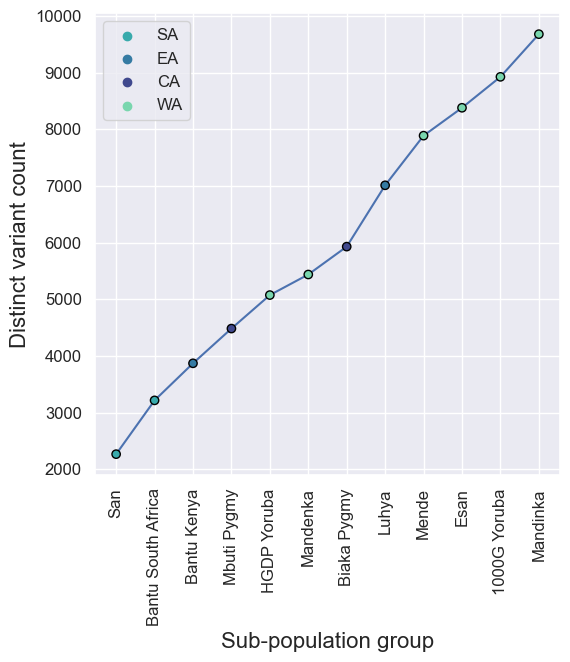

In [55]:
fig, ax = plt.subplots(figsize=(6, 6)) # Set a custom size for this figure

# Assign the plot colouring

color_dict = dict({'SA':'#38AAAC',
                  'EA':'#357BA3',
                  'CA': '#40498E',
                  'WA': '#79D6AE'})

# Create scatter plot

cum_variant_lineplot = sns.scatterplot(
    data=collated_af_subpop,
    x="SUB_POP",
    y="CUMULATIVE_TOTAL_VARIANTS",
    marker="o",
    hue="REG",
    palette=color_dict,
    edgecolor='black',
    linewidth = 1,
    zorder=100
)

# Create a line plot

cum_variant_lineplot = sns.lineplot(
    data=collated_af_subpop,
    x="SUB_POP",
    y="CUMULATIVE_TOTAL_VARIANTS",
    marker=None,
    zorder=1
)

# Set x and y labels, and xtick rotation

cum_variant_lineplot.set(xlabel="Sub-population group", ylabel="Distinct variant count")
plt.xticks(rotation=90)

plt.savefig("..\Results\Figures\Variant_discovery_curve.png", dpi=1200, bbox_inches="tight")
plt.show()

#### Comparison of shared and unique genetic variation among the different African regions

In [56]:
# Group by variant and region. Remove rows with variants with alternate allele counts of 0. These variants are not present in the region.
region_specific_allele_counts = ih_allele_counts.groupby(by=["VAR_NAME", "ID", "POS", "REF", "ALT", "VARIANT_TYPE", "GENE", "REG"]).sum()
region_specific_allele_counts = region_specific_allele_counts[~(region_specific_allele_counts.IH_ALT_CTS == 0)].drop(columns="CORR_IH_AF").reset_index()

# Drop rows with region set to African, Recent African, African American or African Caribbean
region_specific_allele_counts = region_specific_allele_counts[~((region_specific_allele_counts.REG == "Recent African") | (region_specific_allele_counts.REG == "African") | (region_specific_allele_counts.REG == "ACB") | (region_specific_allele_counts.REG == "ASW"))]

# Generate a dictionary with lists of variants for each region
region_variant_dict = {}
for region in region_specific_allele_counts.REG.unique():
    region_variants = region_specific_allele_counts[region_specific_allele_counts.REG == region]["ID"].unique()
    region_variant_dict[region] = region_variants

# Generate a set with the union of all variants across the lists
all_variants = set()
for value in region_variant_dict.values():
    all_variants.update(value)

# Find overlap in values for each region
variant_overlap = pd.DataFrame()

for region in region_specific_allele_counts.REG.unique():
    region_variant_overlap = pd.DataFrame([[e in region_variant_dict[region]] for e in all_variants], columns = [region])
    variant_overlap = pd.concat([variant_overlap, region_variant_overlap], axis=1)

# Group values
variant_overlap_grouped = variant_overlap.groupby(by = variant_overlap.columns.tolist()).size()
variant_overlap_grouped.head(5)

C:\Users\User\AppData\Local\Temp\ipykernel_8520\3417848193.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  region_specific_allele_counts = ih_allele_counts.groupby(by=["VAR_NAME", "ID", "POS", "REF", "ALT", "VARIANT_TYPE", "GENE", "REG"]).sum()


EA     SA     WA     CA   
False  False  False  True      550
              True   False    3110
                     True      234
       True   False  False     342
                     True       68
dtype: int64

Plot overlap of variants for each African region

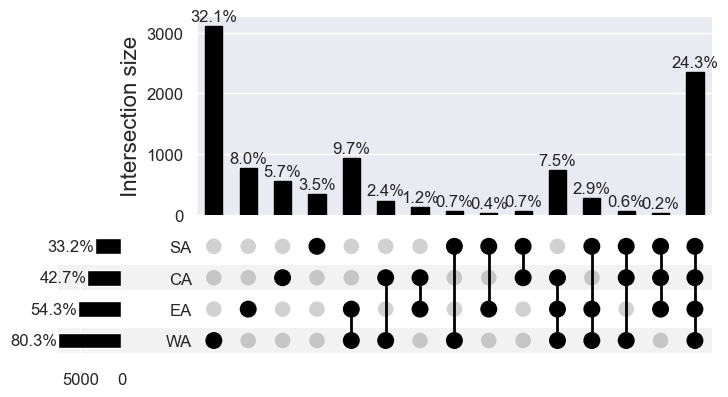

In [57]:
upsetplot.plot(variant_overlap_grouped, show_percentages=True, orientation='horizontal', facecolor="black")
plt.savefig("..\Results\Figures\Shared_and_population_specific_variation.png", dpi=1200)
plt.show()

#### Comparison of shared and unique genetic variation among South African subpopulations

In [58]:
# Subset by Southern Africa subpopulations. Remove rows with variants with alternate allele counts of 0. These variants are not present in the subpopulations.
sa_allele_counts = ih_allele_counts[ih_allele_counts.REG == "SA"]
sa_allele_counts = sa_allele_counts[~(sa_allele_counts.IH_ALT_CTS == 0)].drop(columns="CORR_IH_AF").reset_index(drop=True)

# Rename subpopulations
sa_allele_counts = sa_allele_counts.replace({"SUB_POP": constants.SUBPOP_RENAME})

# Generate a dictionary with lists of variants for each region
sa_variant_dict = {}
for sub_pop in sa_allele_counts.SUB_POP.unique():
    sa_variants = sa_allele_counts[sa_allele_counts.SUB_POP == sub_pop]["ID"].unique()
    sa_variant_dict[sub_pop] = sa_variants

# Generate a set with the union of all variants across the lists
all_variants = set()
for value in sa_variant_dict.values():
    all_variants.update(value)

# Find overlap in values for each region
variant_overlap = pd.DataFrame()

for sub_pop in sa_allele_counts.SUB_POP.unique():
    sa_variant_overlap = pd.DataFrame([[e in sa_variant_dict[sub_pop]] for e in all_variants], columns = [sub_pop])
    variant_overlap = pd.concat([variant_overlap, sa_variant_overlap], axis=1)

# Group values
variant_overlap_grouped = variant_overlap.groupby(by = variant_overlap.columns.tolist()).size()
variant_overlap_grouped.head(5)

Bantu South Africa  San  
False               True      685
True                False     949
                    True     1582
dtype: int64

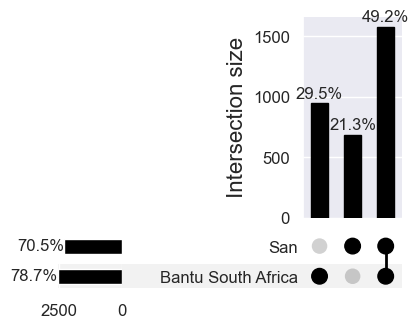

In [59]:
# Plot overlap of variants for each subpopulation 
upsetplot.plot(variant_overlap_grouped, show_percentages=True, orientation='horizontal', facecolor="black")
plt.savefig("..\Results\Figures\Shared_and_population_specific_variation_SA.png", dpi=1200)
plt.show()